In [1]:
from numpy.fft import fftn, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import sys
import math

from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

arcmin = 2.908882086656e-4 # [rad] ... PI / 180 / 60 //
arcsec = 4.848136811094e-6 # [rad] ... arcmin / 60 //
dtheta=27

In [2]:
import astropy.cosmology
#from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

def arcsec_to_cMpc(l_arcsec, z):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc)
    return l_cMpc.value 

def freq_to_comdis(nu_obs, nu_rest):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)
    return cosmo.comoving_distance(z).to(u.Mpc).value

In [4]:
NLINE = 17
line_names = ["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "CO(12-11)", "CO(13-12)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122"]
freq_rest_dict = {
    "CO(1-0)": 115.271,
    "CO(2-1)": 230.538,
    "CO(3-2)": 345.796,
    "CO(4-3)": 461.041,
    "CO(5-4)": 576.268,
    "CO(6-5)": 691.473,
    "CO(7-6)": 806.652,
    "CO(8-7)": 921.800,
    "CO(9-8)": 1036.912,
    "CO(10-9)": 1151.985,
    "CO(11-10)": 1267.014,
    "CO(12-11)": 1381.995,
    "CO(13-12)": 1496.922,
    "[CII]158": 1900.537,
    "[OIII]88": 3393.006,
    "[NII]205": 1461.131,
    "[NII]122": 2459.381
}

def load_data(side_length=3600, fmin=139, fmax=170, dtheta=48, R=500, noise=False):
    fname_id = f"./output_TNG300-1_model0/map_{side_length}sec_fmin{fmin}_fmax{fmax}_angular{dtheta}_spectral{R}"

    fname = fname_id + ".h5"
    with h5py.File(fname, "r") as f:
        frequency = f["/frequency"][:] * 1e-9  # [GHz]
        intensity = f["/intensity"][:]

    shape = intensity.shape
    print("freqency shape: ", frequency.shape)
    print("intensity shape: ", intensity.shape)

    intensity_line = np.zeros((NLINE, shape[0], shape[1], shape[2]))
    for i in range(NLINE):
        with h5py.File(f"{fname_id}_{i}.h5", "r") as f:
            intensity_line[i] = f["/intensity"][:]

    CO = np.zeros((shape[0], shape[1], shape[2]))
    for i in range(NLINE):
        with h5py.File(f"{fname_id}_{i}.h5", "r") as f:
            intensity_line[i] = f["/intensity"][:]
            if "CO" in line_names[i]:
                CO += f["/intensity"][:]

    if noise:
        noise_filename = "noise_template_1e-3.npy"
        if os.path.exists(noise_filename):
            noise_Jy = np.load(noise_filename)
            print("Loaded existing noise template.")
        else:
            mu = 0
            sigma = 1e-3  # [Jy/beam]
            noise_Jy = np.random.normal(mu, sigma, intensity.shape)
            np.save(noise_filename, noise_Jy)
            print("Generated and saved new noise template.")
            
        noise_Jy_sr = noise_Jy / (dtheta * arcsec) ** 2
        intensity += noise_Jy_sr
    
    return frequency, intensity, intensity_line, CO
    

def my_fft(X, L=None, b=1.): # b = 2 * np.pi for inverse FT
    dim = len(X.shape)
    N = np.array(X.shape)

    if L is None:
        L = N
    elif np.isscalar(L):
        L = L * np.ones(dim)

    dx = np.array([float(l)/float(n) for l, n in zip(L, N)])
    Vx = np.prod(dx) # volume of a cell

    #freq = [fftfreq(n, d=d)*2*np.pi for n, d in zip(N, dx)]
    freq = [fftfreq(n, d=d)*2*np.pi for n, d in zip(N, dx)]
    ft = Vx * fftn(X) * np.sqrt(1/np.abs(b)) ** dim

    return ft, freq

def calc_noise_power(sigma_noise_Jy_beam, dV):
    sigma_N = sigma_noise_Jy_beam / ( dtheta * arcsec )**2
    P_noise = sigma_N**2 * dV

    return P_noise


def calc_power(freq_obs, intensity, intensity2=None, noise_sigma=1e-3, noise_sigma2=1e-3, side_length=3600, line_name="CO(1-0)", dlogk=0.2, with_hlittle=True, logkpara_min=-10, logkperp_min=-10): 
    """
    input:
        freq: (N,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [arbitrary unit]
        side_length: side length [arcsec]
        line_name: line name for which the distance is calculated
        dlogk: bin width for logk
        with_hlittle: if True, multiply h
        logkpara_min: minimum value of logkpara
        logkperp_min: minimum value of logkperp
    output:
        k: (Nk,) wavenumber [h/cMpc^-1]
        power1d: (Nk,) power spectrum [input unit^2 * (cMpc/h)^3]
    """
    hlittle = cosmo.H0.value / 100
    
    redshifts = freq_rest_dict[line_name] / freq_obs - 1
    redshift_mean = np.mean(redshifts)
    nu_rest = freq_rest_dict[line_name]

    print(f"Use {line_name} rest-frame frequency")
    print(f"redshift: {redshifts[0]:.2f} - {redshifts[-1]:.2f} (mean: {redshift_mean:.2f})")
    
    Lx = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Ly = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Lz = freq_to_comdis(freq_obs[0], nu_rest) - freq_to_comdis(freq_obs[-1], nu_rest) 

    dx = Lx / intensity.shape[0]
    dy = Ly / intensity.shape[1]
    dz = Lz / intensity.shape[2]
    
    L = np.array([Lx, Ly, Lz])
    dL = np.array([dx, dy, dz])
    if with_hlittle:
        L *= hlittle
        dL *= hlittle # [cMpc/h]^3
    V = np.prod(L) 
    dV = np.prod(dL) 

    ## Fourier transform
    ft, freq = my_fft(intensity, L=L)

    if intensity2 is not None:
        if intensity.shape != intensity2.shape:
            raise ValueError("intensity and intensity 2 must have the same shape")
        ft2, _ = my_fft(intensity2, L=L)
        auto_power1 = np.real( ft * np.conj(ft) ) / V
        auto_power2 = np.real( ft2 * np.conj(ft2) ) / V
        power_noise2 = calc_noise_power(noise_sigma2, dV)
    else:
        ft2 = ft

    power_spectrum = np.real( ft * np.conj(ft2) ) / V
    power_noise = calc_noise_power(noise_sigma, dV)
    kx, ky, kz = np.meshgrid(freq[0], freq[1], freq[2], indexing='ij')

    ## compute angular-averaged power spectrum
    logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
    logkpara = np.log10(np.abs(kz))
    logkperp = np.log10(np.sqrt(kx**2 + ky**2))
    
    logk_bins = np.arange(-1.4, 1.3, dlogk)#dk=k*dlogk
    
    power1d = np.zeros(len(logk_bins) - 1)
    power1d_err = np.zeros(len(logk_bins) - 1)
    for i in range(len(logk_bins) - 1):
        mask = (logk >= logk_bins[i]) & (logk < logk_bins[i+1]) & (logkpara > logkpara_min) & (logkperp > logkperp_min)
        Nk = mask.sum()

        if np.any(mask):
            power1d[i] = np.mean(power_spectrum[mask])
            if intensity2 is not None:
                sigma_1 = auto_power1[mask] + power_noise
                sigma_2 = auto_power2[mask] + power_noise2
                sigma_x = 0.5 * ( power_spectrum[mask]**2 + sigma_1 * sigma_2 )
                power1d_err[i] = np.sqrt( np.mean(sigma_x) )/ np.sqrt(Nk)
            else:
                power1d_err[i] = (power1d[i] + power_noise) / np.sqrt(Nk)

    return 10**(0.5*(logk_bins[1:]+logk_bins[:-1])), power1d, power1d_err


### Show velocity map

In [4]:
def show_ver_map(side_length, fmin, fmax, dtheta, R, frequency, lines_to_show=line_names):
    freq, intensity, intensity_line, CO= load_data(side_length=side_length, fmin=fmin, fmax=fmax, dtheta=dtheta, R=R, noise=False)

    Nmap = len(lines_to_show) + 2
    line_ids = [line_names.index(name) for name in lines_to_show]

    plt.figure(figsize=(Nmap*4, 3))
    plt.subplots_adjust(hspace=1)
    def show_a_ver_map(imap, map, freq=freq, dtheta=dtheta, side_length=side_length, frequency = frequency, vmin=0.0, vmax=2000, label=None, use_log=False):
        plt.subplot2grid((1, Nmap), (0, imap))
        array = np.asarray(frequency)  # 入力をNumPy配列に変換
        iz = (np.abs(array - freq)).argmin()  # 最小差のインデックスを取得
        #iz = np.where((freq<frequency + 1.0)&(freq>frequency - 1.0))[0]
        selected_slices = np.array([map[:, :, iz]])
        map_xy = np.sum(selected_slices, axis=0)
        convolved_image = map_xy

        if use_log: convolved_image = np.log10(map_xy)
        cmap = plt.cm.viridis
        #cmap.set_bad(color=cmap(0))
        plt.imshow(convolved_image, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(label + " " + str(int(frequency)) +"GHz")
        plt.colorbar(label="log I [Jy/sr]")
        plt.yticks([])
        plt.xticks([])
        x = side_length / 5400
        y = side_length / 5400
        plt.xlabel("{:.1f} deg".format(x))
        plt.ylabel("{:.1f} deg".format(y))

    show_a_ver_map(0, intensity, label="total")
    show_a_ver_map(1, CO, label="CO")
    for i, iline in enumerate(line_ids):
        show_a_ver_map(i+2, intensity_line[iline], label=line_names[iline])
def show_map(side_length, fmin, fmax, dtheta, R, lines_to_show=line_names, use_log=False, smoothing=0):
    freq, intensity, intensity_line, CO = load_data(side_length=side_length, fmin=fmin, fmax=fmax, dtheta=dtheta, R=R, noise=False)

    Nmap = len(lines_to_show) + 1
    line_ids = [line_names.index(name) for name in lines_to_show]

    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=1)

    def show_ticks(fmin=fmin, fmax=fmax, freq=freq):
        if fmax - fmin < 150:
            tick_values = [ int(fmin/100) * 100 + 20*i for i in range(10) ]
        else:
            tick_values = [ int(fmin/100) * 100 + 100*i for i in range(10) ]
        tick_values = [v for v in tick_values if v > fmin and v < fmax]
        interpolator = interp1d(freq, np.arange(len(freq)))
        tick_positions = interpolator(tick_values)
        plt.xticks(ticks=tick_positions, labels=tick_values)

    def show_a_map(imap, map, side_length=side_length, iy=0, vmin=None, vmax=None, label=None, use_log=use_log):
        plt.subplot2grid((Nmap,1), (imap,0))
        map_xz = map[:, iy, :]
        if use_log: map_xz = np.log10(map_xz)
        if smoothing > 0:
            map_xz = gaussian_filter(map_xz, sigma=smoothing)
        cmap = plt.cm.viridis
        cmap.set_bad(color=cmap(0))
        plt.imshow(map_xz, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(label)
        plt.colorbar(label="log I [Jy/sr]")
        plt.yticks([])
        x = side_length / 3600
        plt.ylabel("{:.1f} deg".format(x))
        plt.xlabel("frequency [GHz]")
        show_ticks()
    show_a_map(0, intensity, label="total")
    for i, iline in enumerate(line_ids):
        show_a_map(i+1, intensity_line[iline], label=line_names[iline])



freqency shape:  (98,)
intensity shape:  (200, 200, 97)


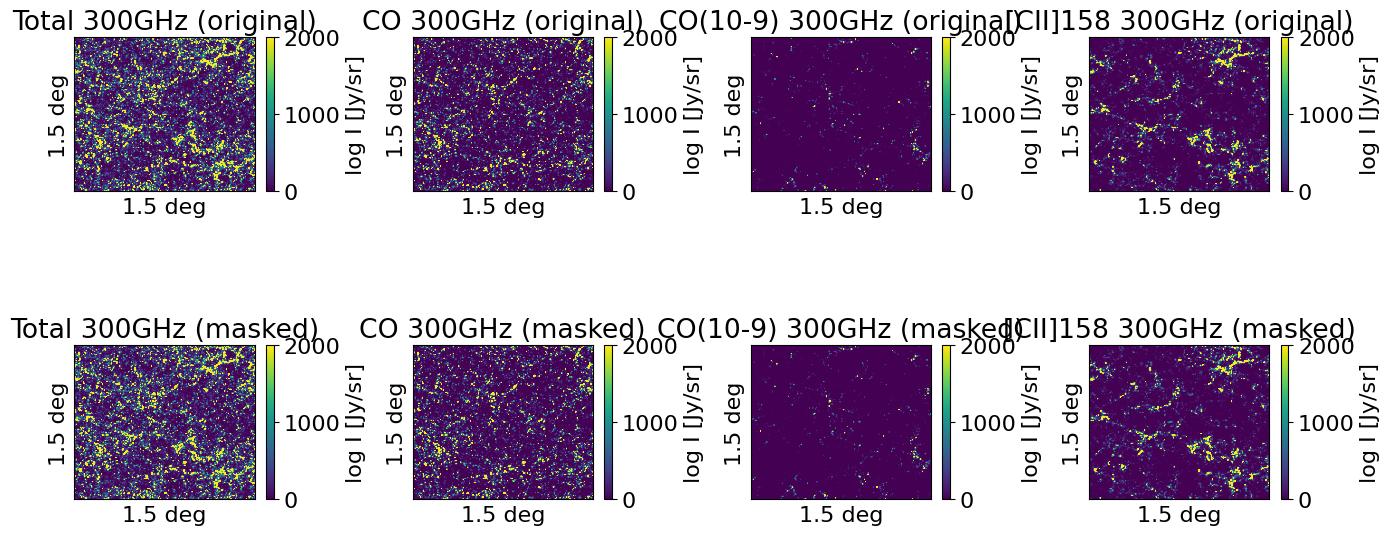

In [30]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(10-9)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


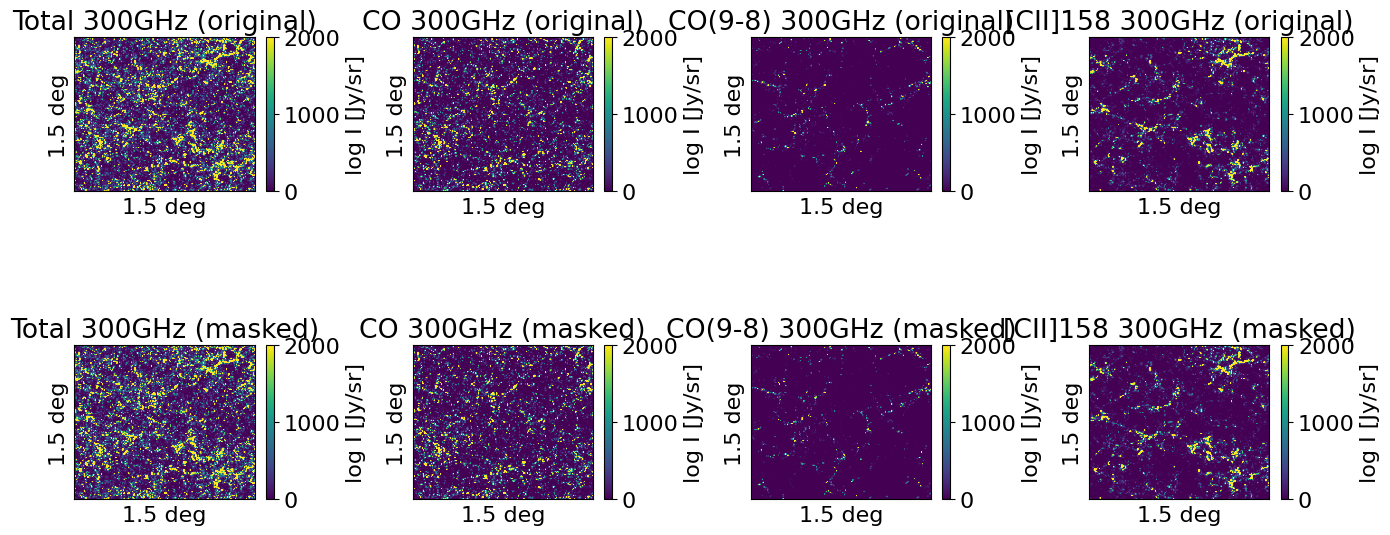

In [29]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(9-8)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


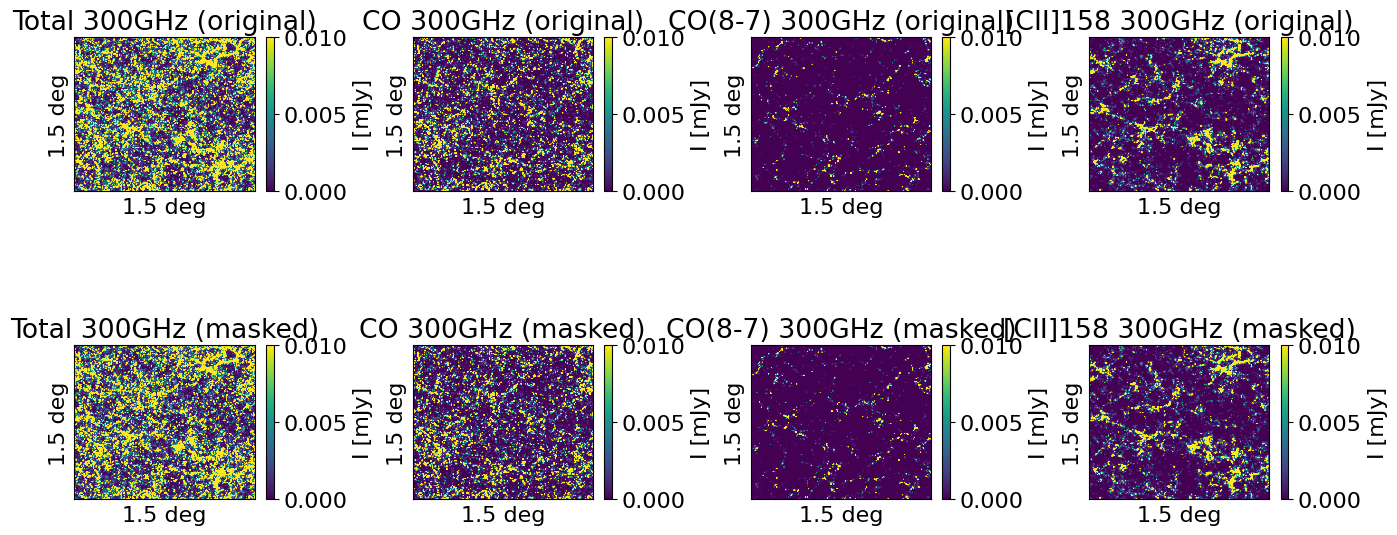

In [25]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(8-7)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


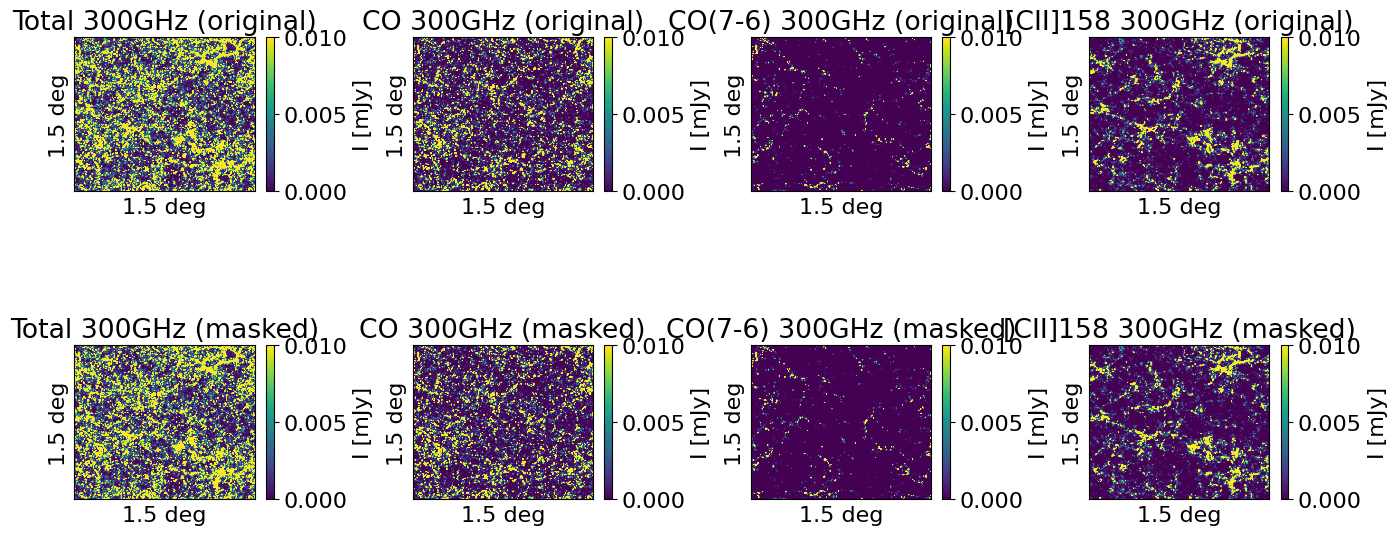

In [24]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(7-6)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


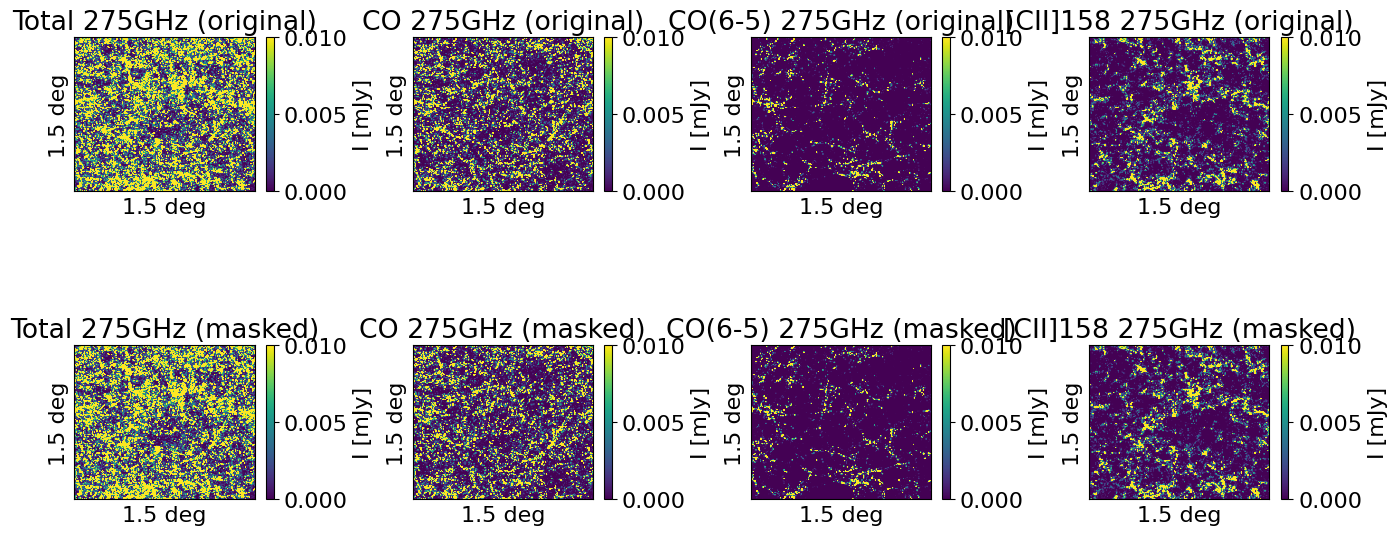

In [26]:
show_ver_map(side_length=5400, fmin=248, fmax=301, dtheta=27, R=500, frequency=275, lines_to_show=[ "CO(6-5)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


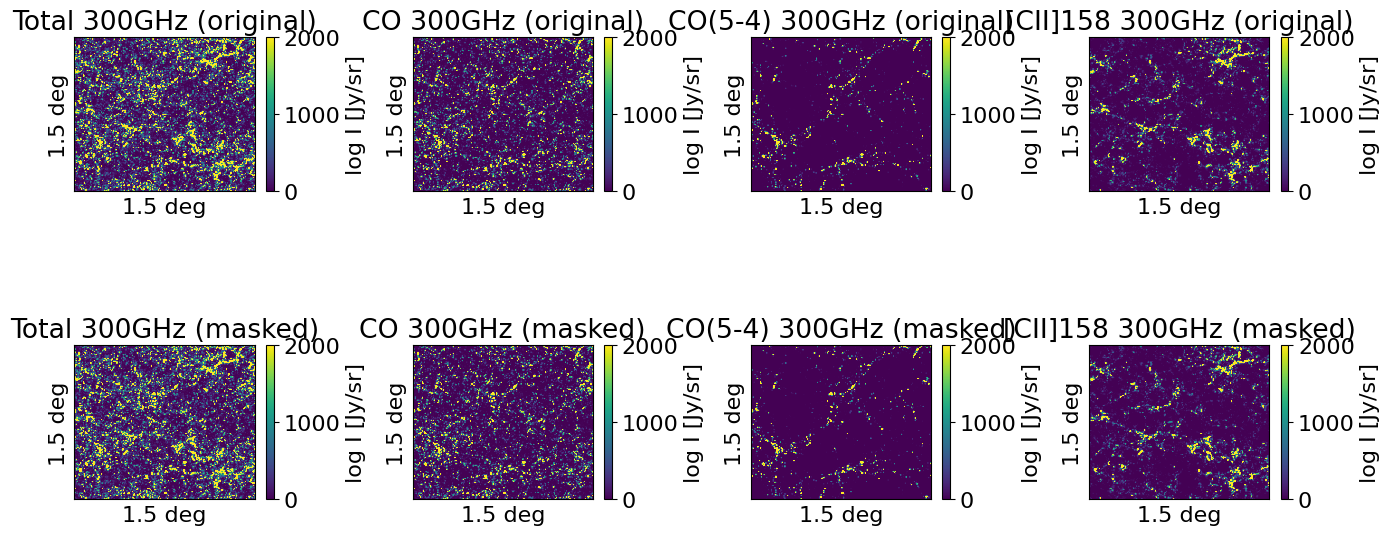

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def mask_intensity(intensity, mask_indices):
    """ 指定されたインデックスに基づいて intensity 配列をマスクする """
    masked_intensity = np.copy(intensity)
    for idx in mask_indices:
        if len(idx) != masked_intensity.ndim:
            print(f"警告: インデックス {idx} の次元数がデータの次元数 {masked_intensity.ndim} と一致しません。")
            continue
        if all(0 <= dim < masked_intensity.shape[i] for i, dim in enumerate(idx)):  
            masked_intensity[idx[0], idx[1], idx[2]] = 0.0  
        else:
            print(f"インデックス {idx} は範囲外です。")
    return masked_intensity

def show_ver_map(side_length, fmin, fmax, dtheta, R, frequency, lines_to_show=line_names):
    """
    縦方向のマップを表示（マスクなし・マスクありの2セット）
    """
    # データ読み込み
    freq, intensity_orig, intensity_line_orig, CO_orig = load_data(
        side_length=side_length, fmin=fmin, fmax=fmax, dtheta=dtheta, R=R, noise=False
    )

    # マスク適用
    mask_indices = np.loadtxt('mask_bright_wn0.5e-3_2.7sigma_km.txt', dtype=int)
    intensity_masked = mask_intensity(intensity_orig, mask_indices)
    CO_masked = mask_intensity(CO_orig, mask_indices)

    intensity_line_masked = np.copy(intensity_line_orig)
    for i in range(len(intensity_line_orig)):
        intensity_line_masked[i] = mask_intensity(intensity_line_orig[i], mask_indices)

    # 描画設定
    Nmap = len(lines_to_show) + 2  # total, CO, lines
    line_ids = [line_names.index(name) for name in lines_to_show]

    plt.figure(figsize=(Nmap * 4, 6))  # 高さを2倍に
    plt.subplots_adjust(hspace=1, wspace=0.5)

    def show_a_ver_map(imap, map_orig, map_masked, freq=freq, dtheta=dtheta, side_length=side_length, 
                        frequency=frequency, vmin=0.0, vmax=2000, label=None, use_log=False):
        """ 1つのデータを2セット（オリジナルとマスク適用）で表示 """
        for col, data, title_suffix in zip(range(2), [map_orig, map_masked], ["(original)", "(masked)"]):
            plt.subplot2grid((2, Nmap), (col, imap))  # 2行のsubplotを設定
            array = np.asarray(freq)
            iz = (np.abs(array - frequency)).argmin()
            selected_slices = np.array([data[:, :, iz]])
            map_xy = np.sum(selected_slices, axis=0)
            convolved_image = np.log10(map_xy) if use_log else map_xy
            cmap = plt.cm.viridis
            plt.imshow(convolved_image, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
            plt.title(f"{label} {int(frequency)}GHz {title_suffix}")
            plt.colorbar(label="log I [Jy/sr]")
            plt.yticks([])
            plt.xticks([])
            x, y = side_length / 3600, side_length / 3600
            plt.xlabel(f"{x:.1f} deg")
            plt.ylabel(f"{y:.1f} deg")

    # 各マップを2セット（オリジナル・マスク適用）で表示
    show_a_ver_map(0, intensity_orig, intensity_masked, label="Total")
    show_a_ver_map(1, CO_orig, CO_masked, label="CO")

    for i, iline in enumerate(line_ids):
        show_a_ver_map(i + 2, intensity_line_orig[iline], intensity_line_masked[iline], label=line_names[iline])

    plt.show()

# 使用例
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(5-4)","[CII]158"])


freqency shape:  (98,)
intensity shape:  (200, 200, 97)


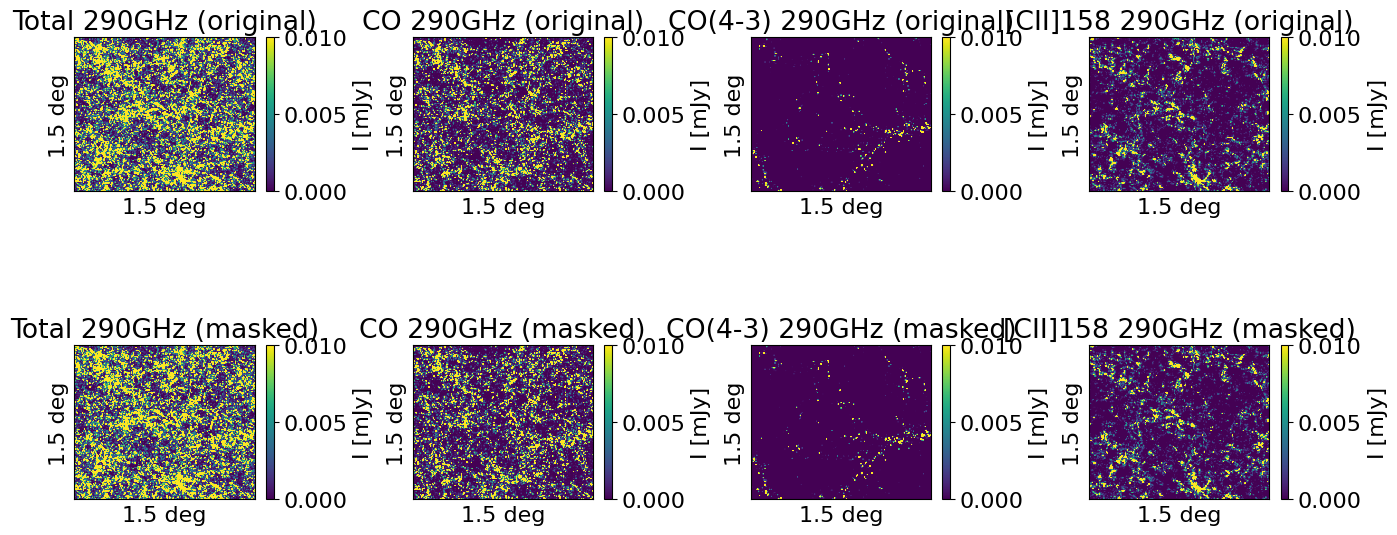

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def mask_intensity(intensity, mask_indices):
    """ 指定されたインデックスに基づいて intensity 配列をマスクする """
    masked_intensity = np.copy(intensity)
    for idx in mask_indices:
        if len(idx) != masked_intensity.ndim:
            print(f"警告: インデックス {idx} の次元数がデータの次元数 {masked_intensity.ndim} と一致しません。")
            continue
        if all(0 <= dim < masked_intensity.shape[i] for i, dim in enumerate(idx)):  
            masked_intensity[idx[0], idx[1], idx[2]] = 0.0  
        else:
            print(f"インデックス {idx} は範囲外です。")
    return masked_intensity

def show_ver_map(side_length, fmin, fmax, dtheta, R, frequency, lines_to_show=line_names):
    """
    縦方向のマップを表示（マスクなし・マスクありの2セット、mJy変換）
    """
    # データ読み込み
    freq, intensity_orig, intensity_line_orig, CO_orig = load_data(
        side_length=side_length, fmin=fmin, fmax=fmax, dtheta=dtheta, R=R, noise=False
    )

    intensity_orig *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
    intensity_line_orig *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
    CO_orig*= (dtheta*arcsec)**2 * 1e3

    # マスク適用
    mask_indices = np.loadtxt('mask_bright_wn0.5e-3_2.7sigma_km.txt', dtype=int)   
    #mask_indices = np.genfromtxt('mask_bright_wn0.5e-3_2.7sigma_km.txt', delimiter=",", dtype=int, invalid_raise=False)
    intensity_masked = mask_intensity(intensity_orig, mask_indices)
    CO_masked = mask_intensity(CO_orig, mask_indices)

    intensity_line_masked = np.copy(intensity_line_orig)
    for i in range(len(intensity_line_orig)):
        intensity_line_masked[i] = mask_intensity(intensity_line_orig[i], mask_indices)

    # 視野角からピクセルの立体角を計算 (steradian)
    
 

    # 描画設定
    Nmap = len(lines_to_show) + 2  # total, CO, lines
    line_ids = [line_names.index(name) for name in lines_to_show]

    plt.figure(figsize=(Nmap * 4, 6))  # 高さを2倍に
    plt.subplots_adjust(hspace=1, wspace=0.5)

    def show_a_ver_map(imap, map_orig, map_masked, freq=freq, dtheta=dtheta, side_length=side_length, 
                        frequency=frequency, vmin=0.0, vmax=0.01, label=None, use_log=False):
        """ 1つのデータを2セット（オリジナルとマスク適用）で表示（mJy変換済み） """
        for col, data, title_suffix in zip(range(2), [map_orig, map_masked], ["(original)", "(masked)"]):
            plt.subplot2grid((2, Nmap), (col, imap))  # 2行のsubplotを設定
            array = np.asarray(freq)
            iz = (np.abs(array - frequency)).argmin()
            selected_slices = np.array([data[:, :, iz]])
            map_xy = np.sum(selected_slices, axis=0) 
            convolved_image = np.log10(map_xy) if use_log else map_xy
            cmap = plt.cm.viridis
            plt.imshow(convolved_image, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
            plt.title(f"{label} {int(frequency)}GHz {title_suffix}")
            plt.colorbar(label="log I [mJy]" if use_log else "I [mJy]")  # 【単位を mJy に修正】
            plt.yticks([])
            plt.xticks([])
            x, y = side_length / 3600, side_length / 3600
            plt.xlabel(f"{x:.1f} deg")
            plt.ylabel(f"{y:.1f} deg")

    # 各マップを2セット（オリジナル・マスク適用）で表示
    show_a_ver_map(0, intensity_orig, intensity_masked, label="Total")
    show_a_ver_map(1, CO_orig, CO_masked, label="CO")

    for i, iline in enumerate(line_ids):
        show_a_ver_map(i + 2, intensity_line_orig[iline], intensity_line_masked[iline], label=line_names[iline])

    plt.show()

# 使用例
show_ver_map(5400, 248, 301, 27, 500, frequency=290, lines_to_show=["CO(4-3)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


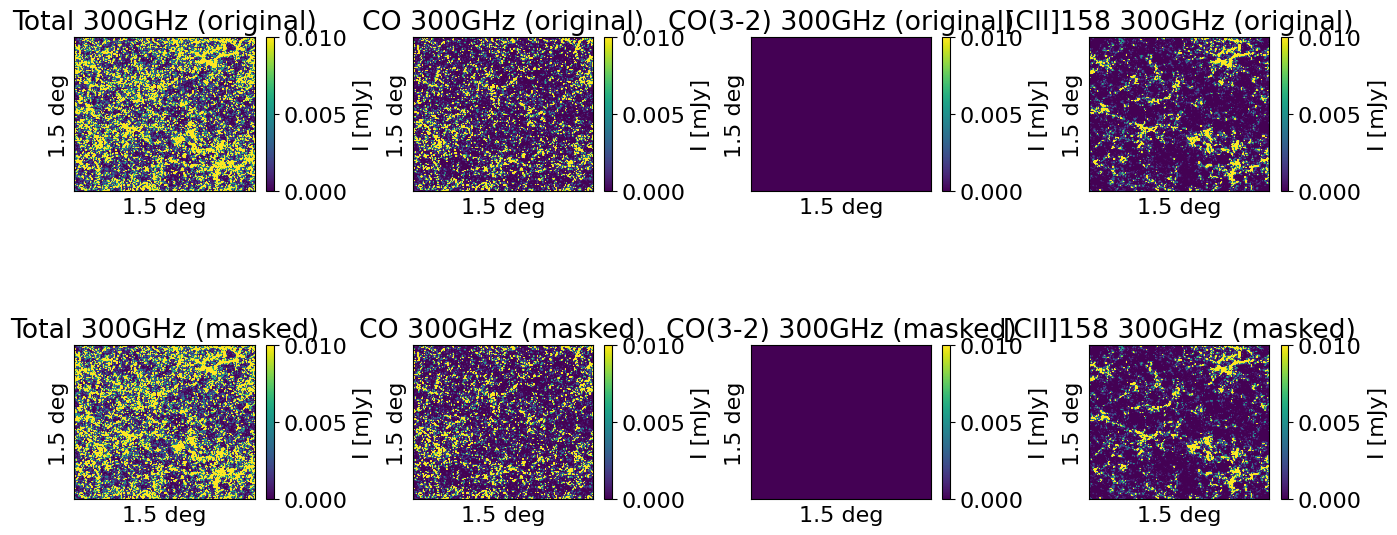

In [21]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(3-2)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


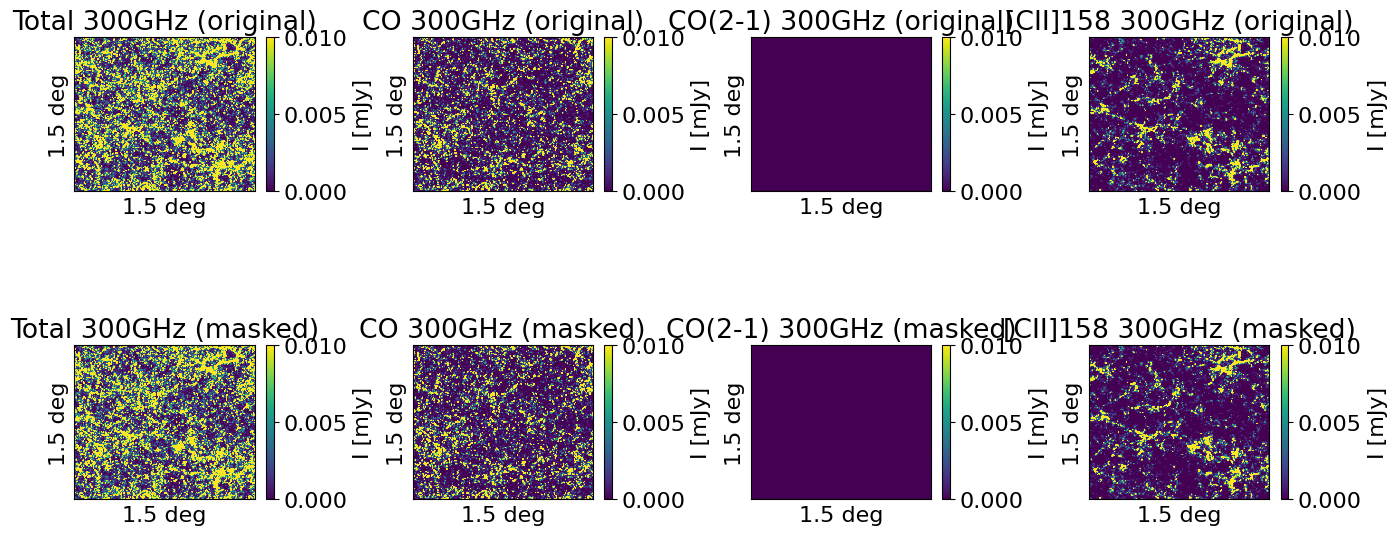

In [17]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(2-1)","[CII]158"])

freqency shape:  (98,)
intensity shape:  (200, 200, 97)


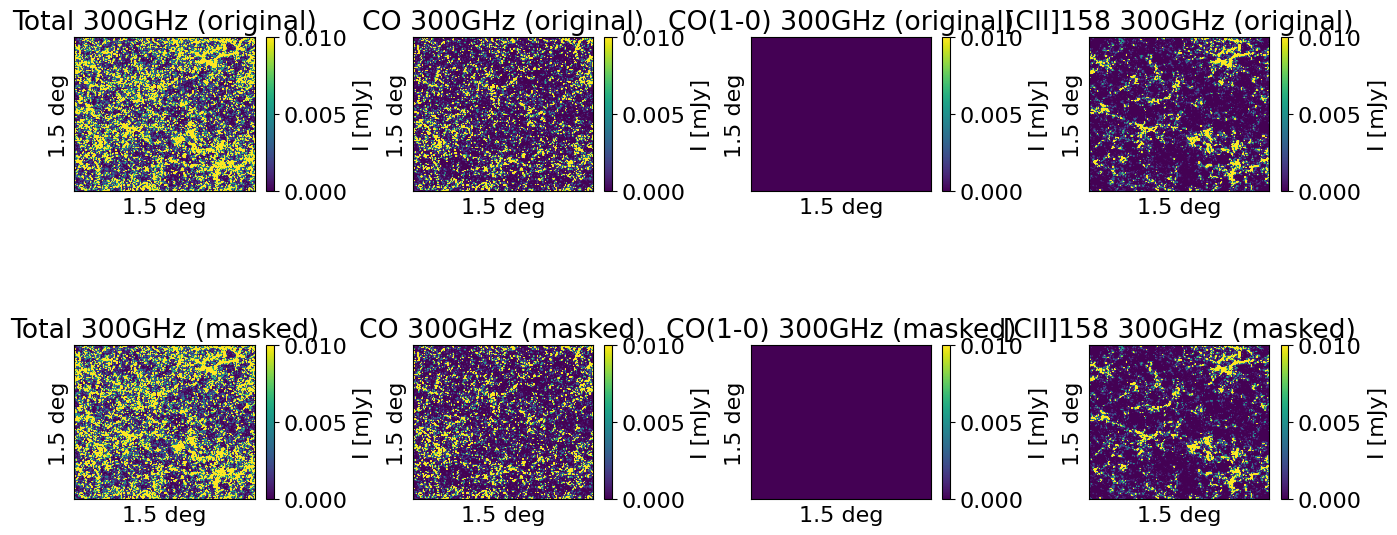

In [18]:
show_ver_map(5400, 248, 301, 27, 500, frequency=300, lines_to_show=["CO(1-0)","[CII]158"])

### Power spectrum

freqency shape:  (98,)
intensity shape:  (200, 200, 97)
Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)


/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:151: RuntimeWarning: divide by zero encountered in log10
  logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:152: RuntimeWarning: divide by zero encountered in log10
  logkpara = np.log10(np.abs(kz))
/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:153: RuntimeWarning: divide by zero encountered in log10
  logkperp = np.log10(np.sqrt(kx**2 + ky**2))


Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)
Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)


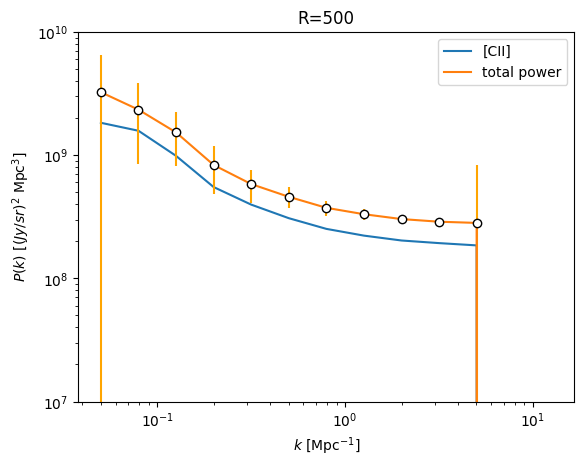

In [8]:
side_length = 5400
freq, intensity, intensity_line, CO = load_data(side_length=side_length, fmin=248, fmax=301, dtheta=27, R=500,noise=False)
with_hlittle = False


## set frequency range 

#freq = freq[40:60]
#ntensity = intensity[:,:,40:60]
#intensity_line = intensity_line[:,:,:,40:60]

## compute power spectrum 
target_line = "[CII]158" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k, power, power_err = calc_power(freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
for i, l in enumerate(line_names):
    if l == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[i], side_length=side_length, line_name=l, with_hlittle=with_hlittle)
 
## mock observation with noise intensity
sigma = 1e-3 / (dtheta * arcsec)**2 # [Jy/sr]
intensity_noise = np.random.normal(0, sigma, intensity.shape)
intensity_w_noise = intensity + intensity_noise
k, power_w_noise, power_err_w_noise = calc_power(freq, intensity_w_noise, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
power_noise_pred = calc_noise_power(1e-3, freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)

## plot power spectrum
plt.xscale("log")
plt.yscale("log")
#plt.title(f"Frequency range: {freq[0]:.0f} - {freq[-1]:.0f} GHz, redshift: 6.07 - 5.81 (mean: 5.94),R=500,RMS=1mJy")
plt.title(f"R=500")
#plt.errorbar(k, power_line, power_line_err,fmt='o',ecolor='black',markeredgecolor = "black",color='w')
plt.plot(k, power_line, label="[CII]")
plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')
plt.plot(k, power,  label="total power")

#plt.plot(k, power_w_noise, label="observed (w/ noise)")
#plt.plot(k, power_w_noise - power_noise_pred, label="observed (obs - predicted noise)")

plt.ylim(1e7,1e10)
plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")
plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ \rm Mpc^3]$")

plt.legend()
#plt.savefig("3d_power_spectrum_b2_factor10_without_noise.png", bbox_inches="tight", pad_inches=0.0)

In [9]:
import numpy as np

"""
# output.txtを読み込んでインデックスのリストを取得
with open('mask_bright_wn0.5e-3_2.7sigma.txt', 'r') as file:
    lines = file.readlines()

# 6列目、7列目、8列目のインデックスを取得（カンマ区切りの列）
mask_indices = []
for line in lines:
    try:
        # 各行をカンマで分割
        columns = line.strip().split(',')
        # 6列目、7列目、8列目のインデックス（0ベースなので、5番目、6番目、7番目のインデックス）
        idx_6th = int(float(columns[5]))  # 6列目（インデックス5）
        idx_7th = int(float(columns[6]))  # 7列目（インデックス6）
        idx_8th = int(float(columns[7]))  # 8列目（インデックス7）
        mask_indices.append((idx_6th, idx_7th, idx_8th))
        #mask_indices.append((idx_6th, idx_7th))
    except (ValueError, IndexError) as e:
        print(f"エラーが発生しました: {e} 行: {line.strip()} の処理に失敗しました。")

#print("読み込んだインデックス:", mask_indices)
"""
def mask_intensity(intensity, mask_indices):
    """
    指定されたインデックスに基づいて intensity 配列をマスクする。
    マスク処理後の intensity 配列を返す。

    Parameters:
    intensity (np.ndarray): マスク対象となるデータ（numpy 配列）
    mask_indices (list of tuples): マスクするインデックスのリスト

    Returns:
    np.ndarray: マスク処理後の intensity 配列
    """
    # intensity のコピーを作成して、そのまま編集しないようにする
    masked_intensity = np.copy(intensity)

    for idx in mask_indices:
        
        # インデックスがデータの次元数と一致するか確認
        if len(idx) != masked_intensity.ndim:
            print(f"警告: インデックス {idx} の次元数がデータの次元数 {masked_intensity.ndim} と一致しません。")
            continue  # 次元数が合わない場合はスキップ

        # インデックスが範囲内かどうかをチェック
        if all(0 <= dim < masked_intensity.shape[i] for i, dim in enumerate(idx)):  # データの範囲内か
            masked_intensity[idx[0], idx[1], idx[2]] = 0.0
            #masked_intensity[idx] = 0  # マスク処理：0でマスク
        else:
            print(f"インデックス {idx} は範囲外です。")

    return masked_intensity  # マスク後の intensity を返す

side_length = 5400
freq, intensity, intensity_line, CO = load_data(side_length=side_length, fmin=248, fmax=301, dtheta=27, R=500,noise=False)
with_hlittle = False
mask_indices = np.loadtxt('mask_bright_wn0.5e-3_2.7sigma_km.txt', dtype=int)
intensity_masked=mask_intensity(intensity, mask_indices)


freqency shape:  (98,)
intensity shape:  (200, 200, 97)


In [10]:
#for i in range(NLINE):
   # if line_names[i] in ["[CII]158"]:  # 特定のライン名でフィルタリング
       # temp = intensity_line[i]  # 対象となるデータを選択

        #for idx in mask_indices:  # mask_indices に対する処理
            # インデックスの次元数がデータの次元数と一致するか確認
          #  if len(idx) != len(temp.shape):
          #      print(f"警告: インデックス {idx} の次元数がデータの次元数 {len(temp.shape)} と一致しません。")
          #      continue  # 次元数が合わない場合はスキップ

            # インデックスが範囲内かどうかをチェック
           # if all(0 <= dim < temp.shape[i] for i, dim in enumerate(idx)):  # データの範囲内か
                #intensity[idx] = 0  # マスク処理：0でマスク
          #  else:
           #     print(f"インデックス {idx} は範囲外です。")


Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)


/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:151: RuntimeWarning: divide by zero encountered in log10
  logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:152: RuntimeWarning: divide by zero encountered in log10
  logkpara = np.log10(np.abs(kz))
/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:153: RuntimeWarning: divide by zero encountered in log10
  logkperp = np.log10(np.sqrt(kx**2 + ky**2))


Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)
Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)
Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)


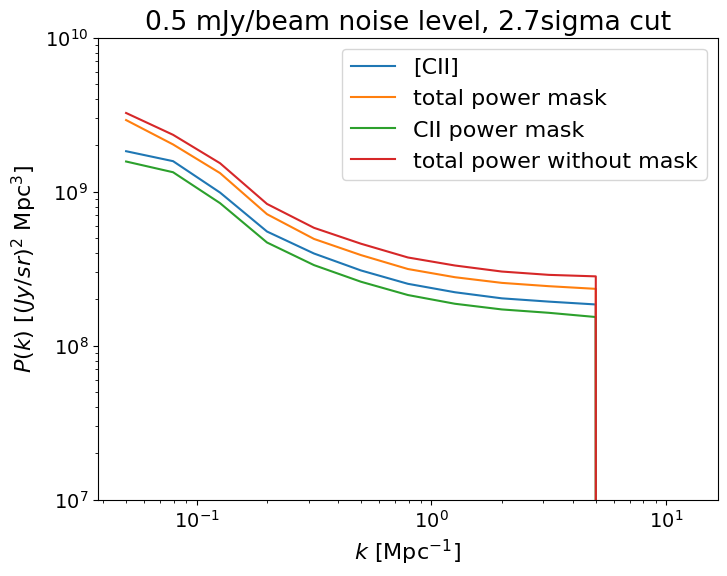

In [11]:
target_line = "[CII]158" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k_mask, power_mask, power_err = calc_power(freq, intensity_masked, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
for i, l in enumerate(line_names):
    if l == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[i], side_length=side_length, line_name=l, with_hlittle=with_hlittle)
        intensity_CII_masked=mask_intensity(intensity_line[i], mask_indices)
        k_line_mask, power_line_mask, power_line_mask_err = calc_power(freq, intensity_CII_masked, side_length=side_length, line_name=l, with_hlittle=with_hlittle)


## mock observation with noise intensity
sigma = 1e-3 / (dtheta * arcsec)**2 # [Jy/sr]
intensity_noise = np.random.normal(0, sigma, intensity_masked.shape)
intensity_w_noise = intensity + intensity_noise
k, power_w_noise, power_err_w_noise = calc_power(freq, intensity_w_noise, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
power_noise_pred = calc_noise_power(1e-3, freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
## Calculate power spectrum for CO before and after masking
#k_co, power_co, power_co_err = calc_power(freq, CO, side_length=side_length, line_name="CO(1-0)", with_hlittle=with_hlittle)
#CO_masked = mask_intensity(CO, mask_indices)
#k_co_mask, power_co_mask, power_co_mask_err = calc_power(freq, CO_masked, side_length=side_length, line_name="CO(1-0)", with_hlittle=with_hlittle)
# plot power spectrum
# 全体のフォントサイズを指定（これでメモリ、ラベル、タイトルの文字サイズが統一されます）
plt.rcParams.update({'font.size': 16})  # 数値を大きくすることで文字が大きくなります
## plot power spectrum
plt.figure(figsize=(8, 6))  # プロット全体のサイズを指定
plt.xscale("log")
plt.yscale("log")
#plt.title(f"Frequency range: {freq[0]:.0f} - {freq[-1]:.0f} GHz, redshift: 6.07 - 5.81 (mean: 5.94),R=500,RMS=1mJy")
#plt.title(f"R=500")
#plt.errorbar(k, power_line, power_line_err,fmt='o',ecolor='black',markeredgecolor = "black",color='w')
plt.plot(k, power_line, label="[CII]")
#plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')
plt.plot(k_mask, power_mask,  label="total power mask")
plt.plot(k_line_mask, power_line_mask,  label="CII power mask")
plt.plot(k, power,  label="total power without mask")
#plt.plot(k_co, power_co, label="CO power without mask", linestyle='dashed')
#plt.plot(k_co_mask, power_co_mask, label="CO power masked", linestyle='dotted')

plt.tick_params(axis='both', which='major', labelsize=14)  # メモリの数字のフォントサイズ

#plt.plot(k, power_w_noise, label="observed (w/ noise)")
#plt.plot(k, power_w_noise - power_noise_pred, label="observed (obs - predicted noise)")

plt.ylim(1e7,1e10)
plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")
plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ \rm Mpc^3]$")
plt.title('0.5 mJy/beam noise level, 2.7sigma cut')
plt.legend()
#plt.savefig("3d_power_spectrum_b2_factor10_without_noise.png", bbox_inches="tight", pad_inches=0.0)

Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)


/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:151: RuntimeWarning: divide by zero encountered in log10
  logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:152: RuntimeWarning: divide by zero encountered in log10
  logkpara = np.log10(np.abs(kz))
/var/folders/zt/54h6r6xn6hv8kl0dwcpwyj0m0000gn/T/ipykernel_53499/3307546983.py:153: RuntimeWarning: divide by zero encountered in log10
  logkperp = np.log10(np.sqrt(kx**2 + ky**2))


Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)
Use [CII]158 rest-frame frequency
redshift: 6.66 - 5.31 (mean: 5.97)


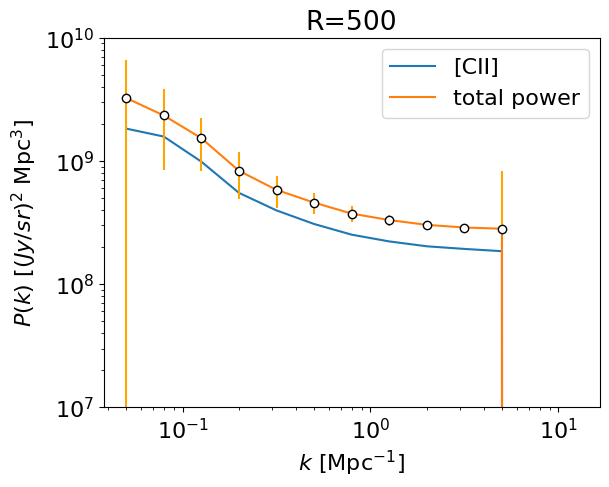

In [12]:
target_line = "[CII]158" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k, power, power_err = calc_power(freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
for i, l in enumerate(line_names):
    if l == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[i], side_length=side_length, line_name=l, with_hlittle=with_hlittle)
 
## mock observation with noise intensity
sigma = 1e-3 / (dtheta * arcsec)**2 # [Jy/sr]
intensity_noise = np.random.normal(0, sigma, intensity.shape)
intensity_w_noise = intensity + intensity_noise
k, power_w_noise, power_err_w_noise = calc_power(freq, intensity_w_noise, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
power_noise_pred = calc_noise_power(1e-3, freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)

## plot power spectrum
plt.xscale("log")
plt.yscale("log")
#plt.title(f"Frequency range: {freq[0]:.0f} - {freq[-1]:.0f} GHz, redshift: 6.07 - 5.81 (mean: 5.94),R=500,RMS=1mJy")
plt.title(f"R=500")
#plt.errorbar(k, power_line, power_line_err,fmt='o',ecolor='black',markeredgecolor = "black",color='w')
plt.plot(k, power_line, label="[CII]")
plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')
plt.plot(k, power,  label="total power")

#plt.plot(k, power_w_noise, label="observed (w/ noise)")
#plt.plot(k, power_w_noise - power_noise_pred, label="observed (obs - predicted noise)")

plt.ylim(1e7,1e10)
plt.xlabel(r"$k \ [\rm Mpc^{-1}]$")
plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ \rm Mpc^3]$")

plt.legend()
#plt.savefig("3d_power_spectrum_b2_factor10_without_noise.png", bbox_inches="tight", pad_inches=0.0)

### Mean intensity

In [34]:
for i in range(NLINE):
    if line_names[i] in ["[CII]158"]:  # 特定のライン名でフィルタリング
        temp = intensity_line[i]

        # mask_indices でループ
        for idx in mask_indices:
            # インデックスがデータの範囲内か確認
            if len(idx) != temp.ndim:
                print(f"警告: インデックス {idx} の次元数がデータの次元数 {temp.ndim} と一致しません。")
                continue  # 次元数が合わない場合はスキップ

            # インデックスが範囲内かどうかをチェック
            if all(0 <= dim < temp.shape[i] for i, dim in enumerate(idx)):  # データの範囲内であるか
                intensity[idx] = 0  # ここでマスク処理：0でマスク
            else:
                print(f"インデックス {idx} は範囲外です。")


In [35]:
#freq, intensity, intensity_line = load_data(side_length=5400, fmin=248, fmax=301, dtheta=27, R=500)
#plot_mean(freq, intensity, intensity_line, lines_to_show=["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122"], ylim=[5, 2e3], nsmooth=10)

freq, intensity, intensity_line, CO = load_data(side_length=5400, fmin=248, fmax=301, dtheta=27, R=500)
plot_mean(freq, intensity, intensity_line, lines_to_show=["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122"], ylim=[5, 2e3], nsmooth=3, logx=True)

freqency shape:  (97,)
intensity shape:  (200, 200, 97)


NameError: name 'plot_mean' is not defined

### Velocity map

freqency shape:  (97,)
intensity shape:  (200, 200, 97)


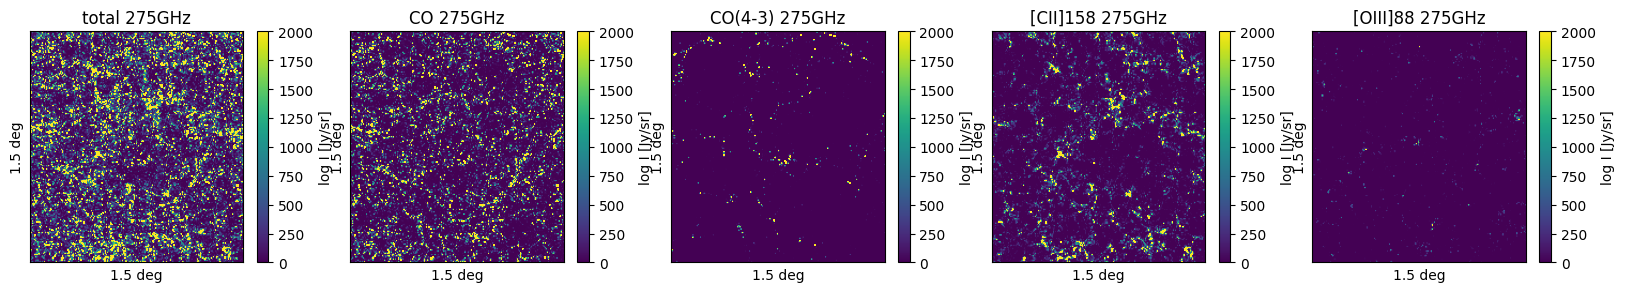

In [11]:
show_ver_map(side_length=5400, fmin=248, fmax=301, dtheta=27, R=500, frequency=275,lines_to_show=[ "CO(4-3)","[CII]158", "[OIII]88"])
plt.savefig("show_ver_map.pdf", bbox_inches="tight", pad_inches=0.0)

### Show map

freqency shape:  (97,)
intensity shape:  (200, 200, 97)


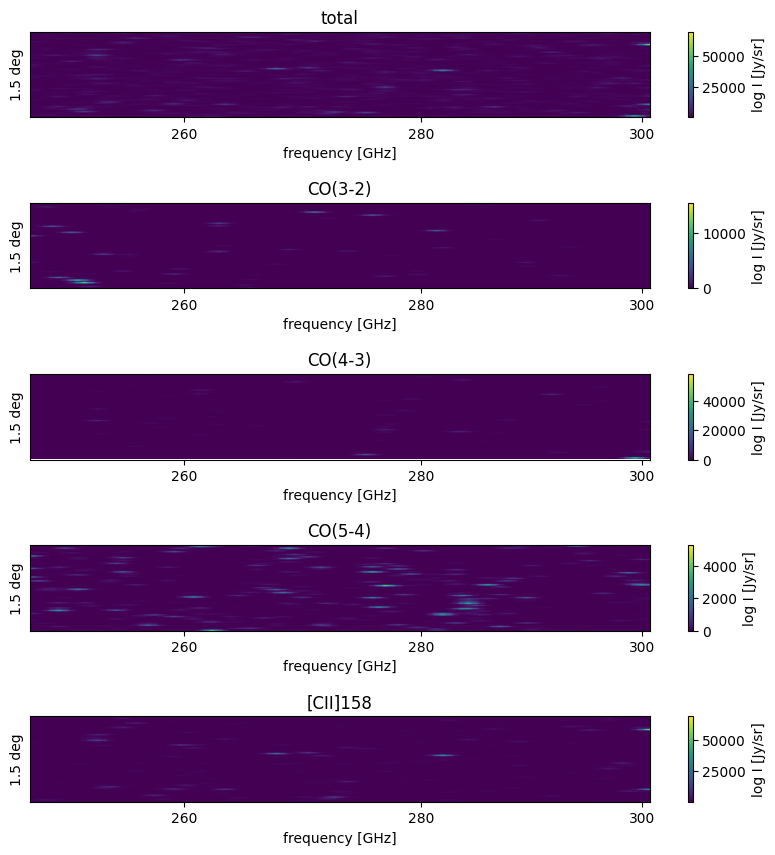

In [10]:
show_map(side_length=5400, fmin=248, fmax=301, dtheta=27, R=500, lines_to_show=["CO(3-2)", "CO(4-3)", "CO(5-4)", "[CII]158"], smoothing=1)
plt.savefig("showmap_1.pdf", bbox_inches="tight", pad_inches=0.0)

### Voxel intensity distribution

freqency shape:  (97,)
intensity shape:  (200, 200, 97)


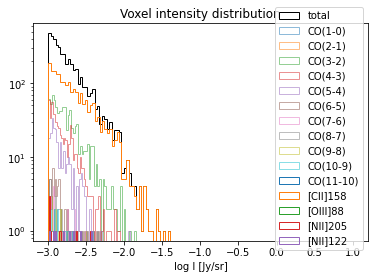

In [12]:
freq, intensity, intensity_line, CO = load_data(side_length=5400, fmin=248, fmax=301, dtheta=27, R=500)

int_min = 1e-3
intensity = intensity.reshape(-1) * ( dtheta * arcsec )**2
intensity_line = intensity_line.reshape(NLINE, -1) * (dtheta * arcsec) ** 2

plt.title("Voxel intensity distribution")

intensity = intensity[intensity > int_min]
plt.hist(np.log10(intensity), bins=50, color="k", label="total", histtype="step")
count = 0
for i in range(NLINE):
    if line_names[i] in ["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122"]:
        temp = intensity_line[i]
        temp = temp[temp > int_min]

        alpha = 0.5 if count < 10 else 1
        plt.hist(np.log10(temp), bins=50, alpha=alpha, label=line_names[i], histtype="step")
        count += 1

plt.xlabel("log I [Jy/sr]")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1,1.1))

### Visualize spectrum 

freqency shape:  (97,)
intensity shape:  (200, 200, 97)


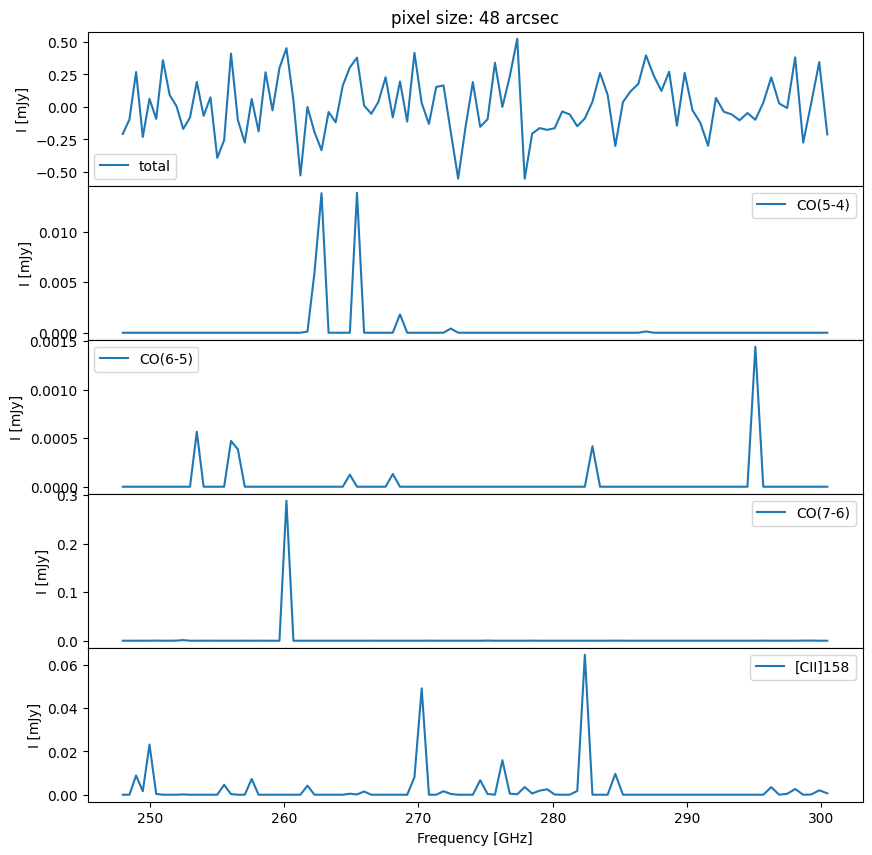

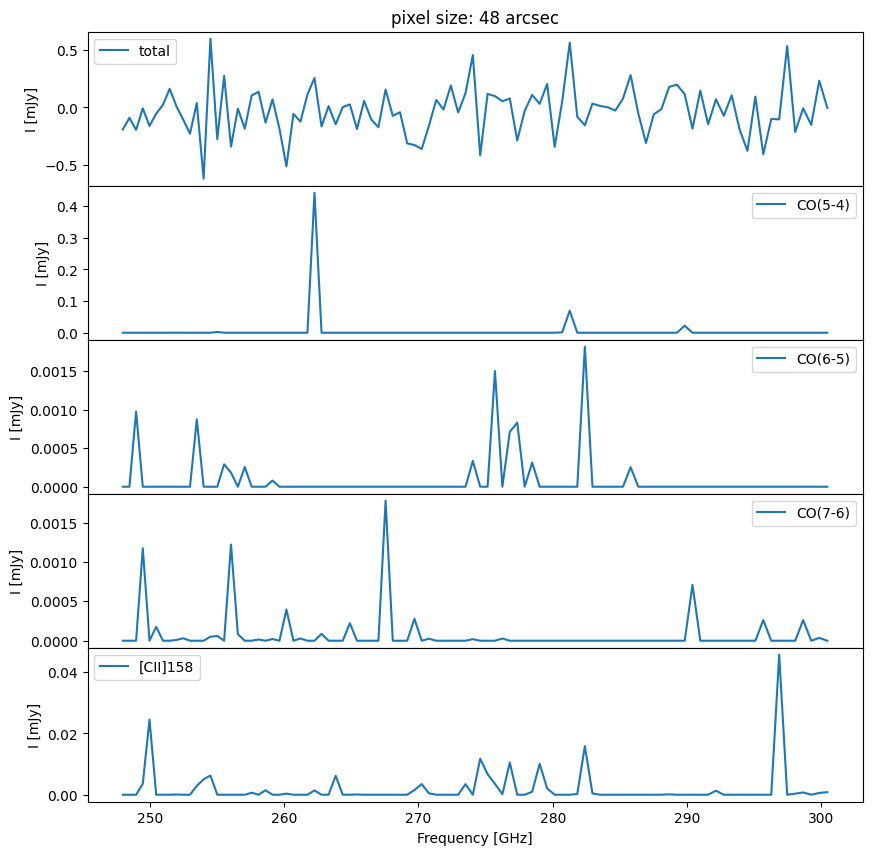

In [103]:
#dtheta = 48
#freq, intensity, intensity_line, CO = load_data(side_length=5400, fmin=248, fmax=301, dtheta=48, R=500,noise=True)

side_length = 5400
freq, intensity, intensity_line, CO = load_data(side_length=side_length, fmin=248, fmax=301, dtheta=27, R=500,noise=True)
with_hlittle = False

intensity *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
intensity_line *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]

lines_to_show = ["CO(5-4)", "CO(6-5)", "CO(7-6)", "[CII]158"]
Nmap = len(lines_to_show) + 1
for i in range(2):
    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=0)
    plt.subplot2grid((Nmap,1),(0,0))
    plt.title("pixel size: 48 arcsec")
    plt.ylabel("I [mJy]")

    plt.plot(freq, intensity[i,0,:], label="total")
    plt.legend()
    count = 1
    for j in range(NLINE):
        if line_names[j] in lines_to_show:
            plt.subplot2grid((Nmap,1),(count,0))
            plt.ylabel("I [mJy]")
            plt.plot(freq, intensity_line[j][i,0,:], label=line_names[j])
            count += 1

            plt.legend()

    plt.xlabel("Frequency [GHz]")
    plt.savefig("spectl_1.pdf", bbox_inches="tight", pad_inches=0.0)      

In [16]:
intensity[:,0,:]

array([[0.0000000e+00, 1.3142675e+01, 1.2436272e+03, ..., 6.4684967e+01,
        4.2138443e+02, 1.3358997e+02],
       [3.0747488e+03, 5.9925697e+01, 1.1919769e+02, ..., 9.8297051e+03,
        2.2472354e+02, 1.7109671e+02],
       [1.8879921e+01, 1.2649205e+02, 1.5837349e+02, ..., 3.9684028e+05,
        5.2382556e+02, 8.8347168e+01],
       ...,
       [1.3320422e+01, 1.7679993e+01, 1.3570378e+02, ..., 2.5734571e+01,
        5.6751377e+03, 4.6910590e+02],
       [5.3369411e+01, 3.0308221e+02, 2.1864404e+02, ..., 1.5631005e+01,
        1.5832486e+02, 5.8977997e+02],
       [4.1037048e+01, 2.7476561e+00, 1.3425195e+03, ..., 9.4668896e+02,
        4.3179555e+04, 2.6972198e+02]], dtype=float32)

In [12]:
import numpy as np
import csv
import os

# 仮定として、intensity がすでに定義されているとします
dtheta = 27
freq, intensity, intensity_line, CO  = load_data(side_length=5400, fmin=248, fmax=301, dtheta=dtheta, R=500,noise=False)

# [CII]のインデックスを取得
cii_index = line_names.index("[CII]158")

# [CII]の強度データを取得
cii_intensity = intensity_line[cii_index]

# 閾値を設定
threshold = 0  # 適切なしきい値を設定

# 閾値を超えるインデックスを取得
cii_indices = np.where(cii_intensity > threshold)  # (x_indices, y_indices, z_indices)

# インデックスの長さに応じて処理を分ける
if len(cii_indices) == 3:
    x_indices, y_indices, z_indices = cii_indices
elif len(cii_indices) == 2:
    x_indices, y_indices = cii_indices
    z_indices = np.zeros_like(x_indices)  # 2Dの場合、zをゼロで埋める
else:
    raise ValueError("Unexpected number of dimensions for intensity data")

# インデックスに対応する強度値を取得
cii_values = cii_intensity[cii_indices]

# 出力ファイルの名前
cii_csv_filename = 'cii_intensity_values_b2_all.txt'

# CSVファイルを書き込み
with open(cii_csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=' ')  # 空白区切り
    writer.writerow(['x', 'y', 'z', 'value'])  # ヘッダー
    
    for x, y, z, value in zip(x_indices, y_indices, z_indices, cii_values):
        writer.writerow([x, y, z, value])

print(f"[CII] thresholded results have been saved to {cii_csv_filename}")


freqency shape:  (98,)
intensity shape:  (200, 200, 97)
[CII] thresholded results have been saved to cii_intensity_values_b2_all.txt
